Imports and Set up
===

In [1]:
import pymc3 as pm
import theano.tensor as T
from numpy import random, sum as nsum, ones, concatenate, newaxis, dot, arange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano

In [2]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import unicode_literals

In [3]:
%matplotlib inline

In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [5]:
plt.rcParams['figure.figsize'] = (15, 10)

plt.rcParams['font.size'] = 16

Linear Regression
===

In [6]:
# Set up basic parameters
num_features = 10
num_observed = 1000

In [7]:
# Choose random values for the actual alpha and betas
alpha_a = random.normal(size=1)

betas_a = random.normal(size = num_features)

# Create fake predictor data
X_train = random.normal(size=(num_observed, num_features))

In [8]:
# Calculate the actual data, but put a bit of noise in
y_a = alpha_a + nsum(betas_a[None,:] * X_train, 1) + random.normal(size=(num_observed))

In [9]:
# Set up the PyMC model
lin_reg_model = pm.Model()
with lin_reg_model:
    
    alpha = pm.Normal('alpha', mu=0, tau=2.**-2, shape=(1))
    betas = pm.Normal('betas', mu=0, tau=2. ** -2, shape=(1, num_features))
    
    # Simulate the noise
    s = pm.Uniform('s', .01, 10, shape=(1))
    
    temp = alpha + T.dot(betas, X_train.T)

    y = pm.Normal('y', temp , s ** -2, observed=y_a)



TypeError: needed name or None but got: alpha

### Strings vs Unicode:

### Tip #1: When in doubt, cast everything as a string!

In [10]:
# Set up the PyMC model
lin_reg_model = pm.Model()
with lin_reg_model:
    
    alpha = pm.Normal(b'alpha', mu=0, tau=2.**-2, shape=(1))
    betas = pm.Normal(b'betas', mu=0, tau=2. ** -2, shape=(1, num_features))
    
    # Simulate the noise
    s = pm.Uniform(b's', .01, 10, shape=(1))
    
    temp = alpha + T.dot(betas, X_train.T)

    y = pm.Normal(b'y', temp , s ** -2, observed=y_a)

Applied interval-transform to s and added transformed s_interval_ to model.


In [11]:
with lin_reg_model:
    #start = find_MAP()
    #h = find_hessian(start)
    

    #step = Metropolis()
    #step = Slice()
    step = pm.NUTS()
    nuts_trace = pm.sample(2e3, step)

KeyboardInterrupt: 

In [ ]:
pm.traceplot(nuts_trace[1000:])

In [ ]:
pm.summary(nuts_trace[1000:])

In [ ]:
alpha_a

In [ ]:
betas_a

Linear Regression: Now with Data!
===

In [37]:
from sklearn.datasets import load_boston

In [38]:
boston = load_boston()

In [39]:
boston_features = pd.DataFrame(boston.data)

In [40]:
boston_features.columns = boston.feature_names

In [41]:
boston_features.CHAS = boston_features.CHAS.astype('bool')

In [42]:
boston_features.RAD = boston_features.RAD.astype('int')

In [43]:
boston_target = pd.DataFrame(boston.target)

In [44]:
from sklearn.linear_model import LinearRegression

In [45]:
from sklearn.cross_validation import train_test_split

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(
    boston_features, boston_target, test_size=0.3)

In [47]:
lr = LinearRegression()

In [48]:
lr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
lr.score(X_test, Y_test)

0.70789627042009107

In [50]:
model_input = theano.shared(X_train)
model_output = theano.shared(Y_train)

In [51]:
# Set up the PyMC model
lin_reg_model_w_data = pm.Model()
with lin_reg_model_w_data:
    
    alpha = pm.Normal(b'alpha', mu=0, tau=2.**-2, shape=(1))
    betas = pm.Normal(b'betas', mu=0, tau=2. ** -2, shape=(1, len(X_test.columns)))
    
    # Simulate the noise
    s = pm.Uniform(b's', .01, 10, shape=(1))
    
    temp = alpha + T.dot(model_input, betas.T)

    y = pm.Normal(b'y', temp , s ** -2, observed=model_output)

Applied interval-transform to s and added transformed s_interval_ to model.


AsTensorError: ('Variable type field must be a TensorType.', <Generic>, <theano.gof.type.Generic object at 0x7f1b195b3c10>)

### DataFrames don't work!

### Tip #2: Turn Dataframes into numpy Arrays

In [52]:
model_input = theano.shared(np.array(X_train))
model_output = theano.shared(np.array(Y_train))

In [53]:
# Set up the PyMC model
lin_reg_model_w_data = pm.Model()
with lin_reg_model_w_data:
    
    alpha = pm.Normal(b'alpha', mu=0, tau=2.**-2, shape=(1))
    betas = pm.Normal(b'betas', mu=0, tau=2. ** -2, shape=(1, len(X_test.columns)))
    
    # Simulate the noise
    s = pm.Uniform(b's', .01, 10, shape=(1))
    
    temp = alpha + T.dot(model_input, betas.T)

    y = pm.Normal(b'y', temp , s ** -2, observed=model_output)

Applied interval-transform to s and added transformed s_interval_ to model.


AsTensorError: ('Variable type field must be a TensorType.', <Generic>, <theano.gof.type.Generic object at 0x7f1b195b3c10>)

### Booleans don't work!

### Tip #3: Cast Booleans as ints

In [54]:
X_train.CHAS = X_train.CHAS.astype(int)

In [56]:
model_input = theano.shared(np.array(X_train))
model_output = theano.shared(np.array(Y_train))

In [57]:
# Set up the PyMC model
lin_reg_model_w_data = pm.Model()
with lin_reg_model_w_data:
    
    alpha = pm.Normal(b'alpha', mu=0, tau=2.**-2, shape=(1))
    betas = pm.Normal(b'betas', mu=0, tau=2. ** -2, shape=(1, len(X_test.columns)))
    
    # Simulate the noise
    s = pm.Uniform(b's', .01, 10, shape=(1))
    
    temp = alpha + T.dot(model_input, betas.T)

    y = pm.Normal(b'y', temp , s ** -2, observed=model_output)

Applied interval-transform to s and added transformed s_interval_ to model.


In [71]:
with lin_reg_model_w_data:
    #start = find_MAP()
    #h = find_hessian(start)
    

    #step = Metropolis()
    #step = Slice()
    #step = pm.NUTS()
    nuts_trace = pm.sample(10e3)

Assigned NUTS to alpha
Assigned NUTS to betas
Assigned NUTS to s_interval_
 [-----------------100%-----------------] 10000 of 10000 complete in 111.6 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a2616f5d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1a21ddfa50>]], dtype=object)

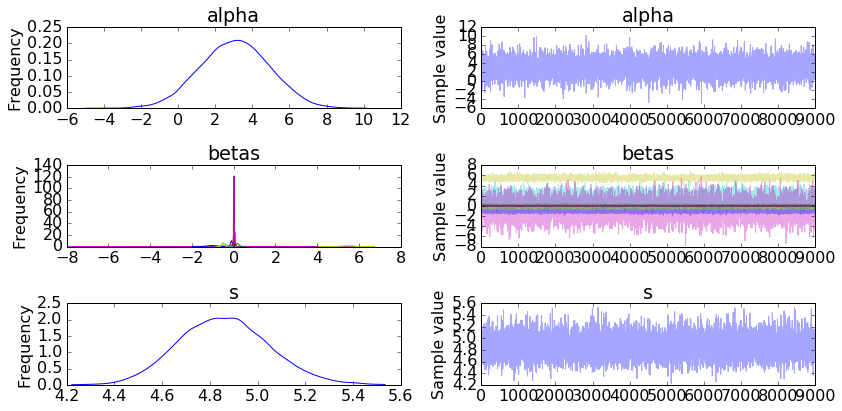

In [72]:
pm.traceplot(nuts_trace[1000:])

In [73]:
pm.summary(nuts_trace[1000:])


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  3.068            1.880            0.022            [-0.616, 6.635]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.596         1.794          3.085          4.344          6.675


betas:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  ..............................[0, :]...............................
  -0.111           0.040            0.000            [-0.186, -0.031]
  0.054            0.016            0.000            [0.022, 0.085]
  -0.008           0.072            0.001            [-0.148, 0.132]
  1.654            0.948            0.009            [-0.153, 3.532]
  -0.691           1.769            0.017            [-4.

In [74]:
lr.coef_

array([[ -1.21143283e-01,   4.92439140e-02,   2.04992744e-02,
          1.99165315e+00,  -1.56596320e+01,   4.09140201e+00,
          2.05367563e-03,  -1.51013525e+00,   2.80810939e-01,
         -1.00815355e-02,  -9.10802496e-01,   9.77788835e-03,
         -5.62939104e-01]])

In [75]:
lr.intercept_

array([ 32.36314267])

In [ ]:
with lin_reg_model_w_data:
    v_params = pm.variational.advi(n=30000)

In [ ]:
plt.plot(v_params.elbo_vals)

In [ ]:
with lin_reg_model_w_data:
    advi_trace = pm.variational.sample_vp(v_params, draws=5000)

In [ ]:
X_test.CHAS = X_test.CHAS.astype(int)

In [ ]:
# Replace shared variables with testing set
model_input.set_value(X_test)
model_output.set_value(Y_test)

In [ ]:
# Create posterior predictive samples
ppc = pm.sample_ppc(advi_trace, model=lin_reg_model_w_data, samples=1000)

In [ ]:
# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['y'].mean(axis=0)

In [ ]:
Y_test.head()

Scoring a Linear Regression Model
===

In [ ]:
pred

In [ ]:
print('ADVI Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Hiearchical Linear Regression
===

In [ ]:
# Set up basic parameters
num_cats = 4
num_per_cat = 30
num_observed = num_per_cat * num_cats
num_features = 3

In [ ]:
# Set up markets
cat = concatenate([[i] * num_per_cat for i in range(num_cats)])

# Simulate the features
features = random.normal(size=(num_observed, num_features))

In [ ]:
# Choose random values to represent the actual alphas and betas
alpha_a = random.normal(size=(num_cats))
beta_a = random.normal(size=(num_cats, num_features))

In [ ]:
# Calculate the actual data, but put a bit of noise in
y = alpha_a[cat] + nsum(beta_a[cat] * features, 1) + random.normal(size=(num_observed))

In [ ]:
# Set up the PyMC model
hlm = pm.Model()
with hlm:
    
    # Both alpha and beta are drawn for the same distributions
    mu_alpha = pm.Normal(b"mu_alpha", 0, 10, shape=(1))
    sigma_alpha = pm.Uniform(b"sigma_alpha", .0, 10, testval=2.)
    
    mu_beta = pm.Normal(b"mu_beta", 0, 10, shape=(1))
    sigma_beta = pm.Uniform(b"sigma_beta", .0, 10, testval=2.)
    
    # Simulate the alphas
    alpha = pm.Normal(b"alpha", mu_alpha, sigma_alpha, shape=(num_cats))
    
    # Simulate the betas
    beta = pm.Normal(b'beta', mu_beta, sigma_beta, shape=(num_cats, num_features))
    
    c = T.constant(cat)
    
    # Simulate the noise
    s = pm.Uniform(b"s", .01, 10, shape=num_cats)

    yd = pm.Normal(b'y', alpha[c] + T.sum(beta[c]*features, 1), s[c] ** -2, observed=y)

    #start = find_MAP()
    #h = find_hessian(start)
    

    #step = Metropolis()
    #step = Slice()
    step = pm.NUTS()

In [ ]:
# Actually sample the model
tr = pm.sample(3e4, step, model=hlm)

In [ ]:
# Plot the variables
pm.traceplot(tr)

In [ ]:
# See a summary
pm.summary(tr)

In [ ]:
alpha_a

In [ ]:
beta_a

Logistic Regression
===

In [ ]:
def numpy_invlogit(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
# Set up basic parameters
num_features = 10
num_observed = 1000

In [ ]:
# Choose random values for the actual alpha and betas
alpha_a = random.normal(size=1)

betas_a = random.normal(size = num_features)

# Create fake predictor data
X_train = random.normal(size=(num_observed, num_features))
X_test =  random.normal(size=(num_observed, num_features))

In [ ]:
# Calculate the outcomes
Y_train = random.binomial(1, numpy_invlogit(alpha_a + np.sum(betas_a[None, :] * X_train, 1)))
Y_test = random.binomial(1, numpy_invlogit(alpha_a + np.sum(betas_a[None, :] * X_test, 1)))

In [ ]:
model_input = theano.shared(X_train)
model_output = theano.shared(Y_train)

In [ ]:
log_reg_model = pm.Model()

with log_reg_model:
    alpha = pm.Normal(b'alpha', mu=0, tau=2.**-2, shape=(1))
    betas = pm.Normal(b'betas', mu=0, tau=2. ** -2, shape=(1, num_features))
    
    #p = invlogit(alpha+T.dot(predictors, betas))
    p = pm.invlogit(alpha + T.sum(betas*model_input, 1))

    o = pm.Bernoulli(b'o', p, observed=model_output)

In [ ]:
with log_reg_model:
    v_params = pm.variational.advi(n=10000)

In [ ]:
plt.plot(v_params.elbo_vals)

In [ ]:
with log_reg_model:
    advi_trace = pm.variational.sample_vp(v_params, draws=5000)

In [ ]:
with log_reg_model:
    # move the chain to the MAP which should be a good starting point
    #start = find_MAP()
    #step = NUTS()

    #trace = sample(3e3, step, start)
    
    step = pm.NUTS(scaling=v_params.stds)

    nuts_trace = pm.sample(8e3, step, start=v_params.means)


In [ ]:
pm.traceplot(nuts_trace[1000:])

In [ ]:
pm.summary(nuts_trace[1000:])

In [ ]:
# Replace shared variables with testing set
model_input.set_value(X_test)
model_output.set_value(Y_test)

In [ ]:
# Create posterior predictive samples
ppc = pm.sample_ppc(advi_trace, model=log_reg_model, samples=1000)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['o'].mean(axis=0) > 0.5

In [ ]:
print('ADVI Accuracy = {}%'.format((Y_test == pred).mean() * 100))

In [ ]:
# Create posterior predictive samples
ppc = pm.sample_ppc(nuts_trace[1000:], model=log_reg_model, samples=1000)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['o'].mean(axis=0) > 0.5

In [ ]:
print('NUTS Accuracy = {}%'.format((Y_test == pred).mean() * 100))

API-ify your model
===

In [ ]:
API_test =  random.normal(size=(1, num_features))

In [ ]:
API_Y_test = random.binomial(1, numpy_invlogit(alpha_a + np.sum(betas_a[None, :] * API_test, 1)))

In [ ]:
API_Y_test

In [ ]:
# Put in some fake data
API_fake_Y = 0

In [ ]:
model_input = theano.shared(API_test)

In [ ]:
API_model = pm.Model()

with API_model:
    alpha = pm.Normal(b'alpha', mu=0, tau=2.**-2, shape=(1))
    betas = pm.Normal(b'betas', mu=0, tau=2. ** -2, shape=(1, num_features))
    
    #p = invlogit(alpha+T.dot(predictors, betas))
    p = pm.invlogit(alpha + T.sum(betas*model_input, 1))

    #o = Bernoulli(b'o', p, shape=(1, 2))
    o = pm.Bernoulli(b'o', p, observed=API_fake_Y)

In [ ]:
# Create posterior predictive samples
ppc = pm.sample_ppc(advi_trace, model=API_model, samples=1000)

In [ ]:
# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['o'].mean(axis=0) > 0.5

In [ ]:
pred

Hiearchical Logistic Regression
===

In [ ]:
# Set up basic parameters
num_cats = 4

# Need lots of data to converge
num_per_cat = 15000
num_observed = num_per_cat * num_cats
num_features = 100

In [ ]:
# Set up markets
cat = concatenate([[i] * num_per_cat for i in range(num_cats)])

In [ ]:
# Simulate the features
features = np.random.normal(size=(num_observed, num_features))

In [ ]:
alpha_a = np.random.normal(size=(num_cats))
beta_a = np.random.normal(size=(num_cats, num_features))

In [ ]:
# Calculate the actual data
p = alpha_a[cat] + nsum(beta_a[cat] * features, 1)

In [ ]:
outcomes = np.random.binomial(1, numpy_invlogit(p))

In [ ]:
hlr = pm.Model()

with hlr:
    # Both alpha and beta are drawn for the same distributions
    mu_alpha = pm.Normal(b"mu_alpha", 0, 100, shape=(1))
    sigma_alpha = pm.Uniform(b"sigma_alpha", .0, 10, testval=2.)
    
    mu_beta = pm.Normal(b"mu_beta", 0, 100, shape=(1))
    sigma_beta = pm.Uniform(b"sigma_beta", 0, 10, testval=2.)
    
    alpha = pm.Normal(b'alpha', mu=mu_alpha, tau=sigma_alpha, shape=(num_cats))
    beta = pm.Normal(b'beta', mu=mu_beta, tau=sigma_beta, shape=(num_cats, num_features))
    
    c = T.constant(cat)
#     print(alpha.random().shape)
#     print(beta.random().shape)
    p = pm.invlogit(alpha[c] + T.sum(beta[c]*features, 1))
    #p = tinvlogit(alpha[m] + T.dot(predictors, beta[m, :]))
    #p = tinvlogit(sum(beta[m] * predictors, 1))
    
    o = pm.Bernoulli(b'o', p, observed=outcomes)

In [ ]:
with hlr:
    v_params = pm.variational.advi(n=10000)

In [ ]:
plt.plot(v_params.elbo_vals)

In [ ]:
with hlr:
    # move the chain to the MAP which should be a good starting point
    #start = find_MAP()
    #step = NUTS(scaling=start)
    #step = Slice()
#     step = NUTS()
#     trace = sample(3e4, step)
    
    step = pm.NUTS(scaling=v_params.stds)
    trace = pm.sample(20000, step, start=v_params.means)

In [ ]:
pm.traceplot(trace)

In [ ]:
pm.summary(trace)

In [ ]:
beta_a

In [ ]:
alpha_a

In [ ]:
pm.forestplot(trace, varnames=['mu_alpha', 'mu_beta', 'alpha', 'sigma_alpha', 'sigma_beta'])